# Introduction

We're curious at how much of an impact having using the full ENCODE annotation has compared to using the filtered genome 10x usually provides that is filtered to protein coding and lincRNA genes.

I have data mapped with both annotations so comparing the genes in common should be an effective test.

In [1]:
import numpy
import scanpy
import anndata
import os
import pandas
from matplotlib import pyplot
from matplotlib import cm
import scipy
from pathlib import Path
#import upsetplot
#import louvain
import sklearn
import seaborn
import logging
from collections import Counter

from pipeline_common import get_gene_id_to_name, load_gtf
from common import (
    scanpy_load_solo_mtx,
    scanpy_load_kallisto_gene_mtx,
    scanpy_load_alevin_mtx,
)
#from cuml.decomposition import PCA
#from cuml.manifold import TSNE


In [2]:
pandas.options.display.max_rows = 200

In [3]:
scanpy.__version__

'1.6.0'

In [4]:
def compute_spearman_pandas(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    assert numpy.all(left.columns == right.columns), "Use the same columns"
    assert numpy.all(left.index == right.index), "Use the same index"

    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.spearmanr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors

def compute_pearson_pandas(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    assert numpy.all(left.columns == right.columns), "Use the same columns"
    assert numpy.all(left.index == right.index), "Use the same index"

    cors=[]
    for c in left.columns:
        cors.append(scipy.stats.pearsonr(left[c], right[c])[0])
    cors = pandas.Series(cors, index=left.columns)
    #[~numpy.isnan(cors)]
    return cors

def compute_spearman_anndata(left, right):
    assert left.shape == right.shape, "Shapes must be the same"
    obs_names = left.obs_names
    if isinstance(left, anndata._core.anndata.AnnData):
        left = left.X.todense()
    if isinstance(right, anndata._core.anndata.AnnData):
        right = right.X.todense()

    #print(left.shape[0])
    #print(left[0].shape)
    #print(right[0].shape)
    cors=[]
    for i in range(left.shape[0]):
        cors.append(scipy.stats.spearmanr(left[:,i], right[:,i])[0])
    cors = pandas.Series(cors, index=obs_names)
    #[~numpy.isnan(cors)]
    return cors


In [5]:
minimal_dir = Path('ENCSR874BOF_e10_5_minimal_limb')
full_dir = Path('ENCSR874BOF_e10_5_limb')

In [6]:
cellranger_name = "Cell Ranger"
star_name = "STAR Solo"
alevin_name = "Salmon Alevin (EM)"
alevin_decoy_name = "Salmon Alevin Decoy (EM)"
kallisto_name = "Kallisto"
kallisto_em_name = "Kallisto (EM)"

In [7]:
minimal_files = {
    cellranger_name: 'ENCSR874BOF_e10_5_minimal_limb/cellranger_filtered.h5ad',
    star_name: 'ENCSR874BOF_e10_5_minimal_limb/solo_filtered.h5ad',
    alevin_name: 'ENCSR874BOF_e10_5_minimal_limb/alevin.h5ad',
    #alevin_decoy_name: 'ENCSR874BOF_e10_5_minimal_limb/alevin_decoy.h5ad',
    kallisto_name: 'ENCSR874BOF_e10_5_minimal_limb/kallisto_filtered.h5ad',
    kallisto_em_name: 'ENCSR874BOF_e10_5_minimal_limb/kallisto_em_filtered.h5ad',
}

In [8]:
full_files = {
    cellranger_name: 'ENCSR874BOF_e10_5_limb/cellranger_filtered.sparse.h5ad',
    star_name: 'ENCSR874BOF_e10_5_limb/solo_filtered.sparse.h5ad',
    alevin_name: 'ENCSR874BOF_e10_5_limb/alevin_filtered.h5ad',
    #alevin_decoy_name:,
    kallisto_name: 'ENCSR874BOF_e10_5_limb/kallisto_filtered.h5ad',
    kallisto_em_name: 'ENCSR874BOF_e10_5_limb/kallisto_em_filtered.h5ad',
}

In [9]:
def verify_existance(files):
    for key in files:
        filename = Path(files[key])
        if not filename.exists():
            print("Missing {} {}".format(key, filename))

verify_existance(minimal_files)
verify_existance(full_files)

In [10]:
def scanpy_load_10x_mtx(filename):
    return scanpy.read_10x_mtx(filename,var_names="gene_ids")

In [11]:
raw_loaders = {
    cellranger_name: scanpy_load_10x_mtx,
    star_name: scanpy_load_solo_mtx,
    alevin_name: scanpy_load_alevin_mtx,
    alevin_decoy_name: scanpy_load_alevin_mtx,
    kallisto_name: scanpy_load_kallisto_gene_mtx,
    kallisto_em_name: scanpy_load_alevin_mtx,
}

h5ad_loaders = {
    cellranger_name: scanpy.read_h5ad,
    star_name: scanpy.read_h5ad,
    alevin_name: scanpy.read_h5ad,
    alevin_decoy_name: scanpy.read_h5ad,
    kallisto_name: scanpy.read_h5ad,
    kallisto_em_name: scanpy.read_h5ad,
}

In [12]:
minimal_dirs = {
    cellranger_name: 'ENCSR874BOF_e10_5_minimal_limb/ENCSR874BOF-minimal-e10_5-count-cells10000/outs/filtered_feature_bc_matrix',
    star_name: 'ENCSR874BOF_e10_5_minimal_limb/star_solo/',
    alevin_name: 'ENCSR874BOF_e10_5_minimal_limb/alevin/',
    alevin_decoy_name: 'ENCSR874BOF_e10_5_minimal_limb/alevin_decoy/',
    kallisto_name: 'ENCSR874BOF_e10_5_minimal_limb/kallisto/genecount/',
    kallisto_em_name: 'ENCSR874BOF_e10_5_minimal_limb/kallisto_em/genecount/',
}

In [13]:
full_dirs = {
    cellranger_name: 'ENCSR874BOF_e10_5_limb/ENCSR874BOF-10x-e10_5-count-cells10000/outs/filtered_feature_bc_matrix',
    star_name: 'ENCSR874BOF_e10_5_limb/diane_star_solo/',
    alevin_name: 'ENCSR874BOF_e10_5_limb/alevin_output_encode_R1_R2/',
    alevin_decoy_name: 'ENCSR874BOF_e10_5_minimal_limb/alevin_decoy/',
    kallisto_name: 'ENCSR874BOF_e10_5_limb/kallisto/genecount/',
    kallisto_em_name: 'ENCSR874BOF_e10_5_limb/kallisto_em/genecount/',
}

In [14]:
def set_all_spines(ax, state):
    for name in ["left", "right", "top", "bottom"]:
        ax.spines[name].set_visible(state)
        ax.tick_params(
            axis='both', 
            which='both', 
            bottom=False,
            labelbottom=False, 
            top=False, 
            labeltop=False,
            right=False,
            labelright=False,
            left=False, 
            labelleft=False)


def plot_algorithm_cell_correlation_histogram_from_matrix(
    minimal, full, *, bins=50, y_annot=0.6, count_nans=False, 
    correlation_name='Spearman',
    xlim=None,
    ax=None,
):
    if ax is None:
        f = pyplot.figure(figsize=(6,6))
        ax = f.subplots(1, 1, sharex=True, sharey=True)

    common_barcodes = list(set(minimal.obs_names).intersection(full.obs_names))
    common_genes = list(set(minimal.var_names).intersection(full.var_names))

    minimal_df = minimal.to_df().T.loc[common_genes, common_barcodes]
    #print("{} minimal filtered {}".format(correlation_name, minimal_df.shape))
    full_df = full.to_df().T.loc[common_genes, common_barcodes]
    #print("{} full filtered {}".format(correlation_name, full_df.shape))

    if correlation_name.lower() == 'spearman':
        spearman = compute_spearman_pandas(minimal_df, full_df)
        spearman = spearman.to_numpy()
        spearman = spearman[~numpy.isnan(spearman)]
        count = len(spearman)
    elif correlation_name.lower() == 'pearson':
        spearman = compute_pearson_pandas(minimal_df, full_df)
        spearman = spearman.to_numpy()
        spearman = spearman[~numpy.isnan(spearman)]
        count = len(spearman)
        
    isnan = numpy.isnan(spearman)
    #print(isnan)
    median = numpy.median(spearman)
    mean = numpy.mean(spearman)
    ax.hist(spearman, bins=bins, density=True)
    nantext=""
    if count_nans:
        nantext="\nNaNs {}".format(isnan.sum())
    ax.annotate(f'Mean {mean:0.2}\nMedian {median:0.2}\nCells {count}{nantext}', xy=(0.1, y_annot), xycoords='axes fraction')
    return ax        

def plot_algorithm_cell_correlation_histogram(
    minimal, full, loaders, *, programs=None, bins=50, y_annot=0.6, count_nans=False, 
    correlation_name='Spearman',
    xlim=None
):
    #fontname = 'Arial'
    fontname = 'DejaVu Sans'
    fontsize = 14    
    if programs is None:
        programs = list(full.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(4*len(programs),6))
    f.suptitle('Per-cell {} correlation'.format(correlation_name), fontsize=fontsize)
    plot_size = len(programs)

    axes = f.subplots(1, plot_size, sharex=True, sharey=True)

    if plot_size == 1:
        axes = numpy.asarray([[axes]])

    for x, name_x in enumerate(programs):
        x_label = name_x
        #print("processing {}".format(name_x))
        minimal_anndata = loaders[name_x](minimal[name_x])
        #print("{} minimal unfiltered {}".format(name_x, minimal_anndata.shape))
        full_anndata = loaders[name_x](full[name_x])
        #print("{} full unfiltered {}".format(name_x, full_anndata.shape))
        ax = axes[x]
        if x == 0:
            ax.set_ylabel('count')
        ax.set_xlabel('{} correlation'.format(correlation_name))
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.set_title(name_x)

        plot_algorithm_cell_correlation_histogram_from_matrix(
            minimal_anndata, full_anndata, 
            count_nans=count_nans, 
            correlation_name=correlation_name,
            ax=ax)
        
    #f.tight_layout()
    return f

# Spearman correlation between per gene and cell counts

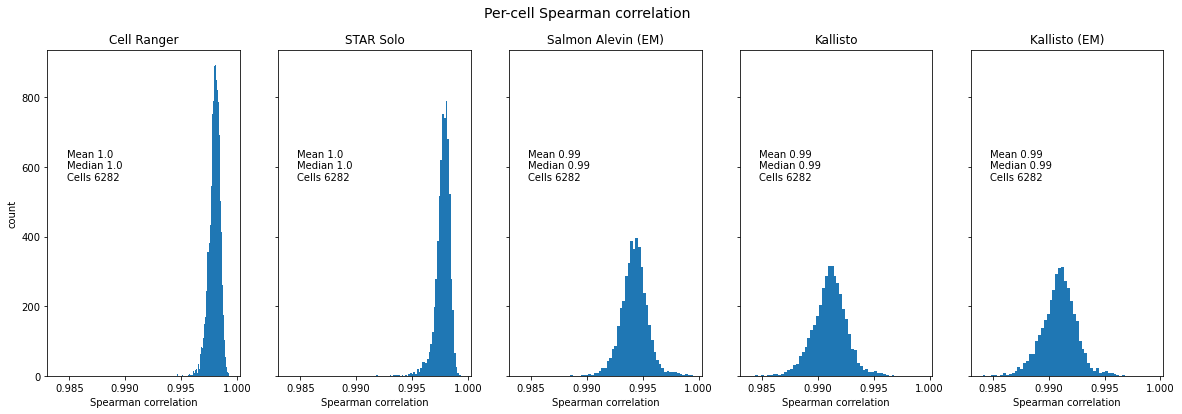

In [15]:
f = plot_algorithm_cell_correlation_histogram(minimal_files, full_files, h5ad_loaders, correlation_name='Spearman')

# Pearson correlation between per gene and cell counts

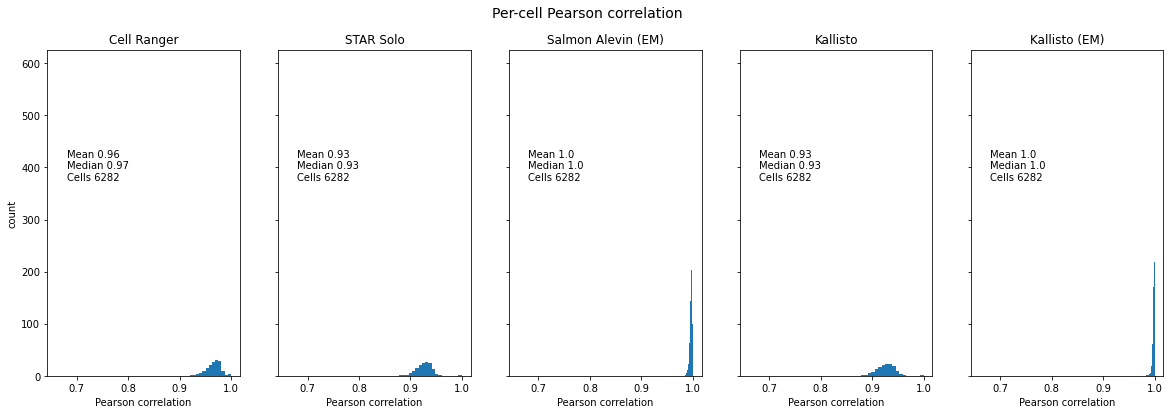

In [16]:
f = plot_algorithm_cell_correlation_histogram(minimal_files, full_files, h5ad_loaders, correlation_name='Pearson')

In [17]:
def plot_algorithm_cell_correlation_mrad(
    minimal, full, loaders, *, programs=None, bins=50, y_annot=0.6, count_nans=False, 
    correlation_name='Spearman',
    xlim=None,
    log=True,
):
    #fontname = 'Arial'
    fontname = 'DejaVu Sans'
    fontsize = 14    
    if programs is None:
        programs = list(full.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(4*len(programs),6))
    f.suptitle('Per-cell mean relative absolute distance', fontsize=fontsize)
    plot_size = len(programs)

    axes = f.subplots(1, plot_size, sharex=True, sharey=True)

    if plot_size == 1:
        axes = numpy.asarray([[axes]])

    for x, name_x in enumerate(programs):
        x_label = name_x
        #print("processing {}".format(name_x))
        minimal_anndata = loaders[name_x](minimal[name_x])
        #print("{} minimal unfiltered {}".format(name_x, minimal_anndata.shape))
        full_anndata = loaders[name_x](full[name_x])
        #print("{} full unfiltered {}".format(name_x, full_anndata.shape))
        
        common_barcodes = list(set(minimal_anndata.obs_names).intersection(full_anndata.obs_names))
        common_genes = list(set(minimal_anndata.var_names).intersection(full_anndata.var_names))
        minimal_df = minimal_anndata.to_df().T.loc[common_genes, common_barcodes]
        full_df = full_anndata.to_df().T.loc[common_genes, common_barcodes]
        rad = (numpy.abs(minimal_df - full_df) / (minimal_df + full_df)).fillna(0)
        radm = rad.mean(axis=0)
        #print('radm', radm.shape)
        
        ax = axes[x]        
        if x == 0:
            if log:
                ax.set_ylabel("log(count)")
            else:
                ax.set_ylabel('count')
        ax.set_xlabel('$mean_{genes} \\frac{|a-b|}{max(a,b)}$')
        if xlim is not None:
            ax.set_xlim(xlim)
        ax.set_title(name_x)
        ax.hist(radm, bins=50)
        if log:
            ax.set_yscale('log')
    return f
        

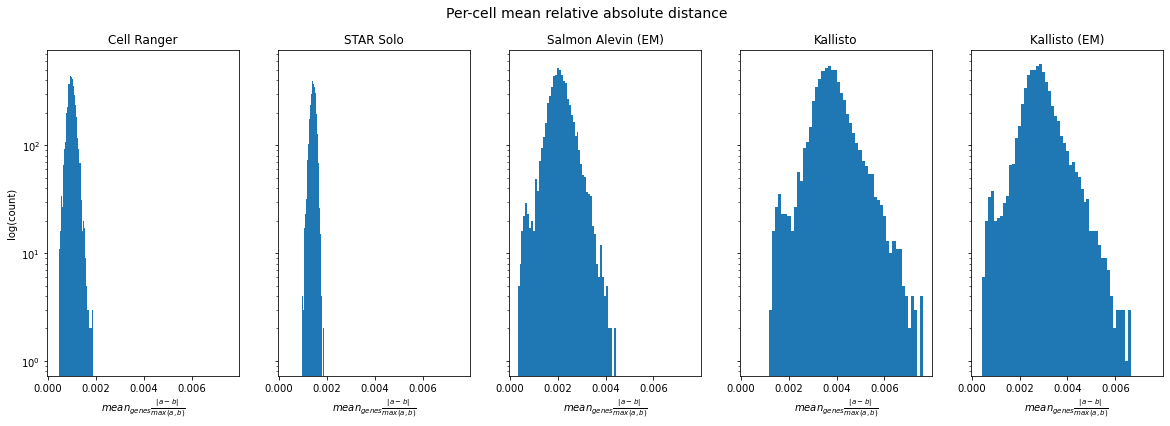

In [18]:
f = plot_algorithm_cell_correlation_mrad(minimal_files, full_files, h5ad_loaders, log=True)

# Mean relative absolute difference between cells in normal space

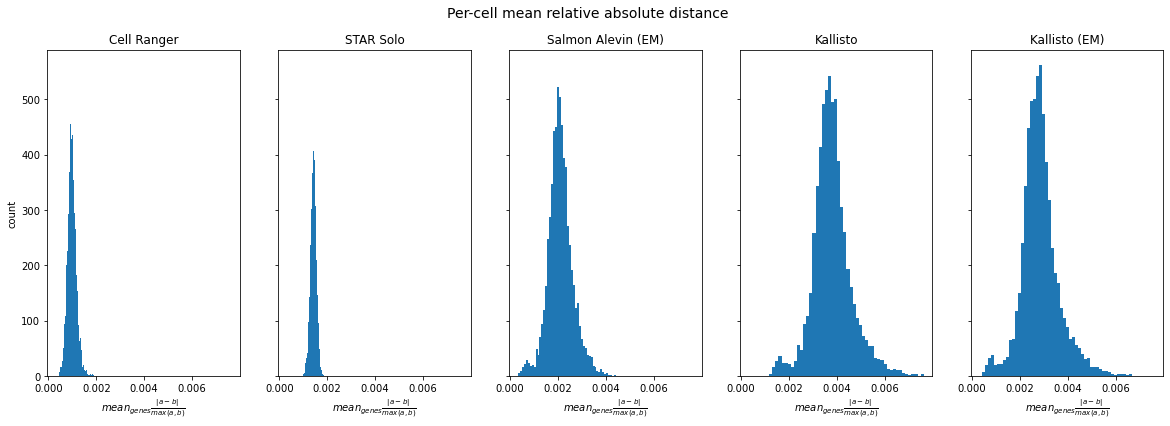

In [19]:
f = plot_algorithm_cell_correlation_mrad(minimal_files, full_files, h5ad_loaders, log=False)

In [29]:
def plot_algorithm_cell_rads(
    minimal, full, loaders, *, programs=None, bins=50, y_annot=0.6, count_nans=False, 
    xlim=None,
    log=True,
):
    #fontname = 'Arial'
    fontname = 'DejaVu Sans'
    fontsize = 14    
    if programs is None:
        programs = list(full.keys())
    cell_hists = {}
    f = pyplot.figure(figsize=(4*len(programs),6))
    f.suptitle('Per-cell sum of relative absolute distance', fontsize=fontsize)
    plot_size = len(programs)

    axes = f.subplots(1, plot_size, sharex=True, sharey=True)

    if plot_size == 1:
        axes = numpy.asarray([[axes]])

    most_different_genes = {}
    for x, name_x in enumerate(programs):
        x_label = name_x
        #print("processing {}".format(name_x))
        minimal_anndata = loaders[name_x](minimal[name_x])
        #print("{} minimal unfiltered {}".format("max rad", minimal_anndata.shape))
        full_anndata = loaders[name_x](full[name_x])
        #print("{} full unfiltered {}".format("max rad", full_anndata.shape))
        
        common_barcodes = list(set(minimal_anndata.obs_names).intersection(full_anndata.obs_names))
        common_genes = list(set(minimal_anndata.var_names).intersection(full_anndata.var_names))
        minimal_df = minimal_anndata.to_df().T.loc[common_genes, common_barcodes]
        full_df = full_anndata.to_df().T.loc[common_genes, common_barcodes]
        rad = (numpy.abs(minimal_df - full_df) / numpy.maximum(minimal_df, full_df))
        #print('rad', rad.shape)
        rads = rad.sum(axis=0)        
        #print('rads', rads.shape)
        
        most_different_gene = rad.sum(axis=1).sort_values()
        #print(most_different)
        most_different_genes[name_x] = most_different_gene / rad.shape[0]
        
        ax = axes[x]
        if xlim is not None:
            ax.set_xlim(xlim)
        if x == 0:
            if log:
                ax.set_ylabel('log(count)')
            else:
                ax.set_ylabel('count')
        ax.set_xlabel('$\\sum_{genes}{\\frac{|a-b|}{max(a,b)}}$')
        
        ax.set_title(name_x)
        ax.hist(rads, bins=50)
        if log:
            ax.set_yscale('log')
    return f, most_different_genes


# Histogram of sum of relative absolute difference between cells

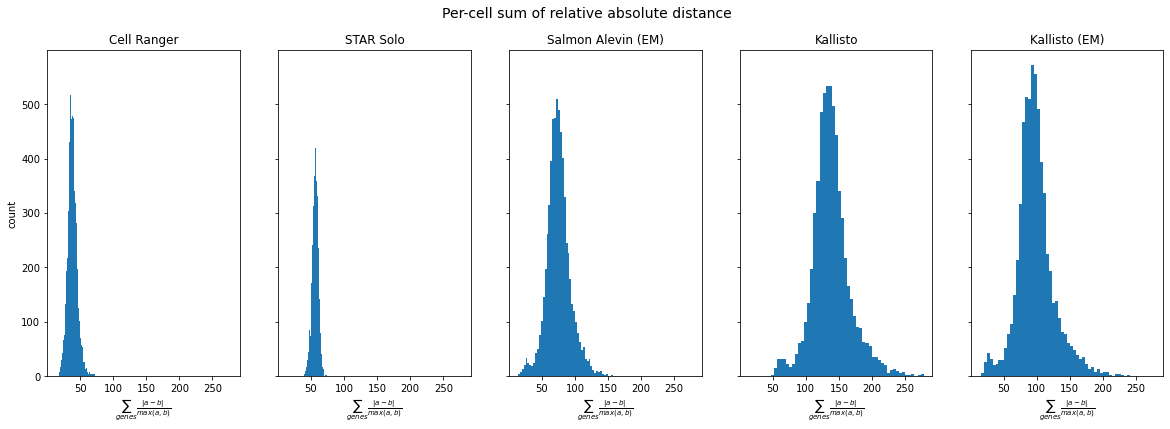

In [30]:
f, mdg = plot_algorithm_cell_rads(minimal_files, full_files, h5ad_loaders, log=False)

In [22]:
store = pandas.HDFStore(Path("~/proj/genome/mm10-M21-male/mm10-M21-male.h5").expanduser(), "r")
gtf = store['/gtf']
store.close()
gene_ids = gtf[gtf['type'] == 'gene'][["gene_id", "gene_name", "gene_type"]].set_index('gene_id')

# Show genes with highest relative absolute error

I was trying to think of a way to find genes that were frequently poorly reproducible between cells between the two genome indexes. I computed the relative absolute difference between each element in the cell x gene matrix, summed across the gene axis and divided by the number of cells. In this case the number of cells in the matrix is a constant, but in theory could change between datasets.

I then adjusted the threshold until I got a manageable number of genes to investigate.

Each individual table was sorted in ascending order by the number of cells normalized relative absolute difference, though by converting into a combined dataframe probably only the first column remains sorted.

The boolean indicates if the gene was unstable in that algorithms run.

$\frac{\sum_{cells}\frac{|a-b|}{max(a,b)}}{N_{cells}} > 0.05$

In [23]:
most_different_ids = {}
for k in mdg:
    different_above_threshold = mdg[k][mdg[k] > .05].index
    print("Difference above threshold", k, len(different_above_threshold))
    for gene_id in different_above_threshold:
        most_different_ids.setdefault(k, {})[gene_id] =  mdg[k][gene_id]
most_different_ids = pandas.DataFrame(most_different_ids).fillna("")
print(most_different_ids.shape)
most_different_ids = most_different_ids.merge(gene_ids, left_index=True, right_index=True, how='left')
most_different_ids

Difference above threshold Cell Ranger 32
Difference above threshold STAR Solo 71
Difference above threshold Salmon Alevin (EM) 56
Difference above threshold Kallisto 96
Difference above threshold Kallisto (EM) 43
(151, 5)


,Cell Ranger,STAR Solo,Salmon Alevin (EM),Kallisto,Kallisto (EM),gene_name,gene_type
ENSMUSG00000038845.11,0.0507824,0.0577593,,,,Phb,protein_coding
ENSMUSG00000098274.7,0.0514442,0.0962031,,0.0906015,,Rpl24,protein_coding
ENSMUSG00000058443.5,0.0746047,,0.117078,,,Rpl10-ps3,protein_coding
ENSMUSG00000075706.10,0.07744,0.121909,,0.126559,,Gpx4,protein_coding
ENSMUSG00000038717.8,0.0811966,0.081447,,0.0795872,,Atp5l,protein_coding
ENSMUSG00000068240.5,0.0819535,0.0507447,,,,Gm11808,protein_coding
ENSMUSG00000054199.17,0.0848314,0.0864614,,0.0863193,0.0719458,Gon4l,protein_coding
ENSMUSG00000065947.3,0.085839,0.0911443,,0.0850185,0.0766789,mt-Nd4l,protein_coding
ENSMUSG00000048234.13,0.0882446,0.0892962,,0.087997,0.0699731,Rnf149,protein_coding
ENSMUSG00000004455.16,0.0886683,0.0959914,,0.0982459,,Ppp1cc,protein_coding


# Count of genes whose sum of relative absolute difference is zero

In [28]:
for k in mdg:
    equal = mdg[k][mdg[k] == 0].index
    print(k, len(equal), "/", mdg[k].shape[0])
    #for gene_id in different_above_threshold:

Cell Ranger 21291 / 31635
STAR Solo 30660 / 31635
Salmon Alevin (EM) 19875 / 31635
Kallisto 16473 / 31635
Kallisto (EM) 16148 / 31635


In [34]:
most_different_ids['gene_name'].values

array(['Phb', 'Rpl24', 'Rpl10-ps3', 'Gpx4', 'Atp5l', 'Gm11808', 'Gon4l',
       'mt-Nd4l', 'Rnf149', 'Ppp1cc', 'Serf2', 'AC132253.9', 'Capza1',
       'Ubb', 'Rpl27', 'Nrbf2', 'Rps12-ps3', 'Ndufb4', 'Ing4', 'Rpl27a',
       'Rpl15', 'Sec61g', 'Slc39a7', 'Mrpl23', 'Rbm42', 'mt-Nd3', 'Rps6',
       'mt-Atp6', 'mt-Co1', 'Atp5g2', 'mt-Co2', 'mt-Co3', 'Cir1', 'Set',
       'Rpl22l1', 'Rps15a', 'Rps8', 'Rps20', 'Rpl12', 'Rpl36', 'Rpl37',
       'Rpl3', 'Cox7c', 'Rps28', 'Snrpf', 'Rpl19', 'Gm8797',
       '1810022K09Rik', 'Bcl7c', 'Amd1', 'Rpl18', 'Hmgb1', 'Rpl30',
       'Gm11361', 'Impdh2', 'Rpl28', 'Hspa8', 'Rps23', 'Rpl23a', 'Rps17',
       'Rps27a', 'Pin4', 'Rps13', 'Rpl31', 'Rpl11', 'Rpl13', 'Rpl6',
       'Rpl36a', 'Rpl10a', 'Rpl17', 'Rpl5', 'Rps7', 'Gm10260', 'Adamts13',
       'Gm42669', 'Gm10687', 'Olfr46', 'Efr3a', 'Xdh', 'Gm35419', 'Wdr31',
       'Nutf2', 'Olfr539', 'Slfn5', 'AC102159.1', 'Gm48610', 'Slx1b',
       'Ppip5k1', 'Vmn2r124', 'Eno1b', 'Gm21897', 'AC160336.1', 'Prdm11'